# Introduction
In this project, we perform a cohort analysis on a fictional e-commerce dataset using SQL and Python. The objective is to explore customer sign-up behavior, track retention over time, and visualize purchasing patterns across different cohorts. This helps businesses understand how long users remain active, when drop-offs occur, and which acquisition months lead to better retention.

We use SQL to query a relational database (cohort_analysis.db) and Python (Pandas, Seaborn, Matplotlib) for data processing and visualization.

In [19]:
from google.colab import files
uploaded = files.upload()


Saving cohort_analysis.db to cohort_analysis (1).db


In [20]:
from operator import attrgetter


# **Task 1: Explore Dataset and Define Cohorts**

We begin by inspecting two tables from the database:

- customers: includes customer_id, sign_up_date, location

- purchases: includes purchase_id, customer_id, purchase_date, total_amount

Customers are grouped into monthly cohorts based on their sign-up date. We then align purchase dates to calculate how many months after sign-up each customer remains active (known as the cohort index).

In [21]:
from sqlalchemy import create_engine
import pandas as pd

# Connect to uploaded database
engine = create_engine('sqlite:///cohort_analysis.db')


In [22]:
from sqlalchemy import inspect

inspector = inspect(engine)
inspector.get_table_names()


['customers', 'purchases']

Preview the Customer Table

In [23]:
query = "SELECT * FROM customers LIMIT 5;"
customers_df = pd.read_sql(query, engine)
customers_df


,customer_id,sign_up_date,location
0,1,2024-03-22,Texas
1,2,2024-01-15,New York
2,3,2024-01-04,California
3,4,2024-02-05,New York
4,5,2024-02-01,Texas


Previous the Purchase table

In [24]:
query = "SELECT * FROM purchases LIMIT 5;"
purchases_df = pd.read_sql(query, engine)
purchases_df


,purchase_id,customer_id,purchase_date,total_amount
0,1,1,2024-05-12,199.08
1,2,1,2024-05-08,93.24
2,3,2,2024-03-12,32.99
3,4,2,2024-02-12,22.16
4,5,2,2024-01-17,121.78


# **Task 2: SQL Queries to Retrieve and Join Data**
We connect to the SQLite database using SQLAlchemy and retrieve data using SQL queries. This query joins customer and purchase data to analyze monthly activity by cohort:


In [25]:
query = """
SELECT
  c.customer_id,
  c.sign_up_date,
  c.location,
  p.purchase_date,
  p.total_amount
FROM customers c
JOIN purchases p ON c.customer_id = p.customer_id;
"""

df = pd.read_sql(query, engine)

# Convert date columns to datetime format
df['sign_up_date'] = pd.to_datetime(df['sign_up_date'])
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df.head()


,customer_id,sign_up_date,location,purchase_date,total_amount
0,1,2024-03-22,Texas,2024-05-08,93.24
1,1,2024-03-22,Texas,2024-05-12,199.08
2,2,2024-01-15,New York,2024-01-15,23.49
3,2,2024-01-15,New York,2024-01-17,121.78
4,2,2024-01-15,New York,2024-02-12,22.16


# **Task 3: Preprocess and Calculate Cohort Index**
In Python, we:

Convert sign_up_date and purchase_date into datetime objects

Create cohort_month and purchase_month using .dt.to_period('M')

Calculate the cohort_index, representing the number of months since the customer signed up

In [26]:
# Create cohort month and purchase month
df['cohort_month'] = df['sign_up_date'].dt.to_period('M')
df['purchase_month'] = df['purchase_date'].dt.to_period('M')

# Calculate cohort index (months since sign-up)
df['cohort_index'] = (df['purchase_month'] - df['cohort_month']).apply(attrgetter('n'))
df.head()


,customer_id,sign_up_date,location,purchase_date,total_amount,cohort_month,purchase_month,cohort_index
0,1,2024-03-22,Texas,2024-05-08,93.24,2024-03,2024-05,2
1,1,2024-03-22,Texas,2024-05-12,199.08,2024-03,2024-05,2
2,2,2024-01-15,New York,2024-01-15,23.49,2024-01,2024-01,0
3,2,2024-01-15,New York,2024-01-17,121.78,2024-01,2024-01,0
4,2,2024-01-15,New York,2024-02-12,22.16,2024-01,2024-02,1


In [34]:
retention_matrix = cohort_data.pivot(
    index='cohort_month',
    columns='cohort_index',
    values='customer_id'
).fillna(0)


# **Task 4: Build and Visualize the Retention Matrix**

We calculate the retention rate as the number of unique customers active each month divided by the total number of signups in that cohort.

Key steps:

1. Drop duplicate customer_id + cohort_month + cohort_index rows

2. Count unique customers per (cohort_month, cohort_index)

3. Normalize by cohort size (number of signups per month)

In [38]:
# True cohort size = total signups per cohort
cohort_sizes_df = df[['customer_id', 'cohort_month']].drop_duplicates()
cohort_sizes = cohort_sizes_df.groupby('cohort_month')['customer_id'].nunique()


In [39]:
# Only count each customer once per cohort_index
deduped_df = df[['customer_id', 'cohort_month', 'cohort_index']].drop_duplicates()

# Count customers active in each cohort index
cohort_data = deduped_df.groupby(['cohort_month', 'cohort_index'])['customer_id'].nunique().reset_index()


In [40]:
retention_matrix = cohort_data.pivot(
    index='cohort_month',
    columns='cohort_index',
    values='customer_id'
).fillna(0)

retention_rates = retention_matrix.divide(cohort_sizes, axis=0).round(2)
retention_rates


cohort_index,0,1,2,3
cohort_month,,,,
2024-01,0.38,0.73,0.65,0.38
2024-02,0.27,0.80,0.63,0.23
2024-03,0.24,0.66,0.72,0.00
2024-04,1.00,1.00,0.00,0.00


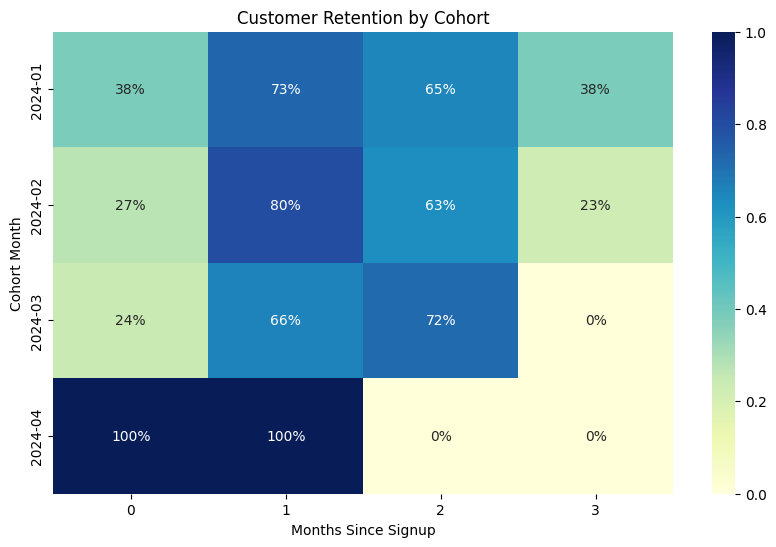

In [41]:
plt.figure(figsize=(10, 6))
sns.heatmap(retention_rates, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Customer Retention by Cohort")
plt.xlabel("Months Since Signup")
plt.ylabel("Cohort Month")
plt.show()


# **Task 5: Interpretation and Business Insights**
The cohort heatmap reveals the following trends:

- Retention is strongest in the first and second months after signup.

- Some cohorts (e.g., 2024-02, 2024-03) retain a large portion of users into the third month.

- A steep drop-off is observed by the 3rd or 4th month across most cohorts.

- The 2024-04 cohort shows full (100%) first-month activity, but lacks long-term data for further tracking.

 # Business Implications:
- Improve onboarding and early engagement strategies to maintain retention past month 1.

- Focus email campaigns or discounts in months 2–3, where most drop-off begins.

- Analyze high-retention cohorts (e.g., February) to replicate successful marketing or UX approaches.